# Dog Breed Classifier

In this project, I built a convolutional neural network (CNN) that can classify the breed of dog from any user-supplied image. If the image is of a human and not a dog, the algorithm will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of the finished project.

## Step 1: Data Import

In this step, we import the data and ready it to be used for classification

### Import Dog Data

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %d total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Data

In [2]:
import random
random.seed(100)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


## Step 2: Detect Humans

We use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on github. We have downloaded one of these detectors and stored it in the haarcascades directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

('Number of faces detected:', 2)


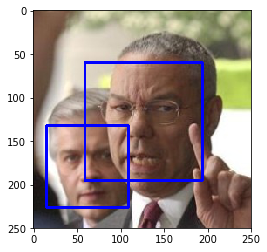

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[100])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The detectMultiScale function executes the classifier stored in face_cascade and takes the grayscale image as a parameter.

In the above code, faces is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, aptly named face_detector, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Test the Face Classifier

Using the code cell below we can test the performance of the face_detector function.

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. You will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays human_files_short and dog_files_short.

After testing you can see that 99% of the first 100 images in human_files have a detected human face, while 11% of the first 100 images in dog_files have a detected human face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_count = 0.0
total = 0.0
for img in human_files_short:
    isPerson = face_detector(img)
    if not isPerson:
        human_count += 1
total = 100 - human_count
percentage = (total/len(human_files_short)) * 100.0
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0.0
for img in dog_files_short:
    isPerson = face_detector(img)
    if isPerson:
        dog_count += 1
percentage = (dog_count/len(dog_files_short)) * 100.0
print('Percentage of dogs misclassified as people: {}%'.format(percentage))

Percentage of humans correctly classified as people: 99.0%
Percentage of dogs misclassified as people: 12.0%


## Step 3: Detect Dogs

In this section, we use a pre-trained ResNet-50 model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories. Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50
# Activate the resnet model with imagenet data
ResNet50_model = ResNet50(weights='imagenet')

### Pre Process data

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [9]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [11]:
human_count = 0.0  
for img in human_files_short:
    isDog = dog_detector(img)
    if isDog:
        human_count += 1
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0.0
for img in dog_files_short:
    isDog = dog_detector(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

Percentage of humans misclassified as dogs:: 2.0%
Percentage of dogs correctly classified as dogs: 100.0%
